In [1]:
import torch
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset
import ipywidgets as widgets
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from pysentimiento.preprocessing import preprocess_tweet
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix


2024-04-03 23:04:10.647265: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 23:04:10.846471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 23:04:10.846545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 23:04:10.880724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 23:04:10.949484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
#pip install torch==2.0.0
#pip install pysentimiento==0.7.2
#pip install evaluate==0.4.0
#pip install datasets==2.14.5

In [3]:
#!pip install pysentimiento transformers datasets accelerate evaluate

In [4]:
#https://huggingface.co/docs/evaluate/base_evaluator

In [5]:
#Three versions of RoBERTuito were
#trained: a cased version which preserves the case found
#in the original tweets, an uncased version, and a deacc
#version, which lower-cases and removes accents on
#tweets.

In [6]:
#Helper Functions

In [7]:
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

In [8]:

f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="macro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="macro"))
    return results

In [9]:
#Read Data

In [10]:
data_files = {"train": "data/train.csv", "validation": "data/val.csv", "test": "data/test.csv"}
ds = load_dataset("csv", data_files=data_files)

In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count'],
        num_rows: 7594
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count'],
        num_rows: 2374
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count'],
        num_rows: 1899
    })
})

In [12]:
#push to hugging face

In [13]:
#https://huggingface.co/settings/tokens

In [14]:
# from huggingface_hub import notebook_login
# notebook_login()

In [15]:
#ds.push_to_hub("jairleo95/social-media-peruvian-sentiment")

In [16]:
ds["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_name': Value(dtype='string', id=None),
 'text_original': Value(dtype='string', id=None),
 'tokenized_text': Value(dtype='string', id=None),
 'sent_token_length': Value(dtype='int64', id=None),
 'sent_bert_token_length': Value(dtype='int64', id=None),
 'char_count': Value(dtype='int64', id=None),
 'Character Count': Value(dtype='int64', id=None)}

In [17]:
ds["test"]["label"][:10]

[1, 0, 0, 0, 0, 2, 1, 0, 2, 2]

In [18]:
df = ds['train'].to_pandas()
df.head()

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count
0,no yuli con eso se va con pendeivis 😞,1,Neutral,No Yuli con eso se va con pendeivis 😞,no yuli con eso se va con pendeivis 😞,9,12,37,37
1,este es más bruto... cosas que necesita el pe...,0,Negative,Este es más bruto... Cosas que necesita el Pe...,este es más bruto cosas que necesita el pe...,27,35,144,144
2,bakan tu video pero el chambar es riko pero pa...,2,Positive,Bakan tu video pero el chambar es riko pero pa...,bakan tu video pero el chambar es riko pero pa...,53,67,267,267
3,no sabes que hacer para llamar la atención par...,0,Negative,no sabes que hacer para llamar la atención par...,no sabes que hacer para llamar la atención par...,18,20,93,93
4,"pe chino dame chamba mano, almenos pa limpiart...",1,Neutral,"Pe CHINO DAME CHAMBA MANO, ALMENOS PA LIMPIART...",pe chino dame chamba mano almenos pa limpiart...,11,14,61,61


In [19]:
# encode label and mapping label name
#df["label"] = df["label"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [20]:
# clean text, lowercase and remove punk
#df["text"] = df["text"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [21]:
df.sample(10)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count
2000,"esa chicha la tome en abancay, es a base de qu...",2,Positive,"Esa chicha la tome en Abancay, es a base de qu...",esa chicha la tome en abancay es a base de qu...,27,39,148,148
1560,"excelente, algún día tengo que visitar y me ll...",2,Positive,"Excelente, algún día tengo que visitar y me ll...",excelente algún día tengo que visitar y me ll...,27,29,151,151
6112,edelciro galvez🤣🤣 mi amigo chino el rencoroso ...,1,Neutral,Edelciro Galvez🤣🤣 Mi amigo chino el rencoroso ...,edelciro galvez🤣🤣 mi amigo chino el rencoroso ...,12,18,73,73
4037,aveces se nos para la mano un poquito 😉 se lo ...,0,Negative,Aveces se nos para la mano un poquito 😉 se lo ...,aveces se nos para la mano un poquito 😉 se lo ...,14,14,66,66
6437,aqui donde radico hce 17 años tdavia no me aco...,1,Neutral,Aqui donde radico hce 17 años tdavia no me aco...,aqui donde radico hce 17 años tdavia no me aco...,30,37,146,146
2068,"tsmpoco creo q ayga gente,aparte detu familia ...",0,Negative,"Tsmpoco creo q ayga gente,aparte detu familia ...",tsmpoco creo q ayga gente aparte detu familia ...,14,22,76,76
7271,a esos que les encanta el tramboyo .la...,2,Positive,A esos que les encanta el tramboyo .la...,a esos que les encanta el tramboyo la...,18,43,104,104
3999,"con ese cuerpazo andaría calata, sigue con fu...",0,Negative,"Con ese cuerpazo andaría calata, sigue con fu...",con ese cuerpazo andaría calata sigue con fu...,20,26,107,107
1043,"cada parada en méxico sus respectivos tacos , ...",1,Neutral,"Cada parada en México sus respectivos tacos , ...",cada parada en méxico sus respectivos tacos ...,26,34,162,162
6225,"que tiene de malo , lo importante es que se ba...",1,Neutral,"Que tiene de malo , lo importante es que se ba...",que tiene de malo lo importante es que se ba...,22,27,97,97


In [22]:
model_name = "pysentimiento/robertuito-base-deacc"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [23]:
# columns = ['input_ids', 'attention_mask', 'label']
# ds.set_format(type='torch', columns=columns)
# ds

In [24]:
preprocessed_ds = ds.map(lambda ex: {"text": preprocess_tweet(ex["text"], lang="es")})

In [25]:
tokenized_ds = preprocessed_ds.map(
    lambda batch: tokenizer(
        batch["text"], padding=True, truncation=True
        ),
    batched=True, batch_size=32
)

Map:   0%|          | 0/1899 [00:00<?, ? examples/s]

In [26]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7594
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2374
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1899
    })
})

In [27]:
tokenized_ds['train']['input_ids'][0][::10]

[0, 614, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [28]:
tokenized_ds['train']['attention_mask'][0][::10]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
tokenized_ds['train']['text'][10]

'tu hermano gemelo manolo... sobrado la haces como su doble..   emoji cara con mano sobre la boca emoji  emoji cara con mano sobre la boca emoji'

In [30]:
tokenized_ds['train']['token_type_ids'][0][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
tokenizer.tokenize('tu hermano gemelo manolo... sobrado la haces como su doble..   emoji cara con mano sobre la boca emoji  emoji cara con mano sobre la boca emoji')

['▁tu',
 '▁hermano',
 '▁gem',
 'elo',
 '▁manolo',
 '...',
 '▁sob',
 'rado',
 '▁la',
 '▁haces',
 '▁como',
 '▁su',
 '▁doble',
 '..',
 '▁',
 '▁',
 '▁emoji',
 '▁cara',
 '▁con',
 '▁mano',
 '▁sobre',
 '▁la',
 '▁boca',
 '▁emoji',
 '▁',
 '▁emoji',
 '▁cara',
 '▁con',
 '▁mano',
 '▁sobre',
 '▁la',
 '▁boca',
 '▁emoji']

In [32]:
text = "No pituca causa🤣"
preprocessed_text = preprocess_tweet(text)
tokenizer.tokenize(preprocessed_text)

['▁no',
 '▁pit',
 'uca',
 '▁causa',
 '▁emoji',
 '▁cara',
 '▁revolviendose',
 '▁de',
 '▁la',
 '▁risa',
 '▁emoji']

In [33]:
ppt = preprocess_tweet("@usuario ESTO es una prueba esdrújula PAPÁ marketing terreno")
tokenizer.tokenize(ppt)

['▁@usuario',
 '▁esto',
 '▁es',
 '▁una',
 '▁prueba',
 '▁es',
 'd',
 'ru',
 'j',
 'ula',
 '▁papa',
 '▁marketing',
 '▁terreno']

In [126]:
#tokenizer.get_vocab()

In [35]:
tokenizer.unk_token

'<unk>'

In [36]:
#!pip install ipdb

In [37]:
#import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [38]:
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    output_dir="robertuito_deacc/checkpoints",
    warmup_ratio=0.1,
    learning_rate=5e-5,
    do_eval=True,
    evaluation_strategy="epoch",
    num_train_epochs=5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [39]:
trainer.train()

{'eval_loss': 0.6388074159622192, 'eval_f1': 0.720163734744432, 'eval_recall': 0.723155250330422, 'eval_runtime': 10.838, 'eval_samples_per_second': 219.043, 'eval_steps_per_second': 27.403, 'epoch': 1.0}
{'eval_loss': 0.6507117748260498, 'eval_f1': 0.7313019023911286, 'eval_recall': 0.7326195285069574, 'eval_runtime': 10.9094, 'eval_samples_per_second': 217.61, 'eval_steps_per_second': 27.224, 'epoch': 2.0}
{'loss': 0.5665, 'grad_norm': 4.0552077293396, 'learning_rate': 3.221288515406163e-05, 'epoch': 2.1}
{'eval_loss': 0.8676197528839111, 'eval_f1': 0.7269692703745397, 'eval_recall': 0.7284301374966583, 'eval_runtime': 11.1344, 'eval_samples_per_second': 213.214, 'eval_steps_per_second': 26.674, 'epoch': 3.0}
{'eval_loss': 1.136397123336792, 'eval_f1': 0.7241790899010975, 'eval_recall': 0.7262912767398196, 'eval_runtime': 10.5026, 'eval_samples_per_second': 226.04, 'eval_steps_per_second': 28.279, 'epoch': 4.0}
{'loss': 0.1415, 'grad_norm': 0.5033333897590637, 'learning_rate': 8.8702

TrainOutput(global_step=1190, training_loss=0.30448239270378563, metrics={'train_runtime': 577.4225, 'train_samples_per_second': 65.758, 'train_steps_per_second': 2.061, 'train_loss': 0.30448239270378563, 'epoch': 5.0})

In [40]:
# Save trained model
trainer.model.save_pretrained("robertuito_deacc/model")

In [41]:
#Test on validation set

In [42]:
evaluation_results = trainer.evaluate(tokenized_ds["test"])

{'eval_loss': 1.2443039417266846, 'eval_f1': 0.7238677750282418, 'eval_recall': 0.7232802885445891, 'eval_runtime': 8.3551, 'eval_samples_per_second': 227.287, 'eval_steps_per_second': 28.486, 'epoch': 5.0}


In [43]:
evaluation_results

{'eval_loss': 1.2443039417266846,
 'eval_f1': 0.7238677750282418,
 'eval_recall': 0.7232802885445891,
 'eval_runtime': 8.3551,
 'eval_samples_per_second': 227.287,
 'eval_steps_per_second': 28.486,
 'epoch': 5.0}

In [44]:
predictions = trainer.predict(tokenized_ds["test"])
predictions

PredictionOutput(predictions=array([[ 0.68899184,  2.6066072 , -4.1727057 ],
       [-1.7843113 , -3.0627193 ,  5.4047976 ],
       [ 2.4641352 , -0.30421463, -2.5051272 ],
       ...,
       [-2.595745  , -2.9646363 ,  6.159081  ],
       [-3.2579777 , -1.7354413 ,  5.634141  ],
       [ 4.9768434 , -1.7644249 , -3.2050898 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 2, 1, 0]), metrics={'test_loss': 1.2443039417266846, 'test_f1': 0.7238677750282418, 'test_recall': 0.7232802885445891, 'test_runtime': 8.2911, 'test_samples_per_second': 229.042, 'test_steps_per_second': 28.706})

In [45]:
len(predictions[0])

1899

In [46]:
true_labels = tokenized_ds["test"]['label']

In [47]:
len(true_labels)

1899

In [48]:
predicted_labels = [np.argmax(pred) for pred in predictions[0]]
classification_rep = classification_report(true_labels, predicted_labels, digits=5)

print(classification_rep)

              precision    recall  f1-score   support

           0    0.80622   0.83107   0.81846       811
           1    0.61090   0.58877   0.59963       552
           2    0.75706   0.75000   0.75351       536

    accuracy                        0.73776      1899
   macro avg    0.72473   0.72328   0.72387      1899
weighted avg    0.73557   0.73776   0.73652      1899



In [49]:
#model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

In [50]:
#Error Analisys

In [104]:
val_df = ds['validation'].to_pandas()
#val_df

In [105]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/2374 [00:00<?, ?it/s]

In [106]:
# add pred into val_df
val_df["pred"] = pred_final

In [107]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [55]:
# filtering false predictions
#val_df = val_df[val_df.control == False]

In [108]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [109]:

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [110]:
confmat

array([[754, 224,  35],
       [121, 442, 128],
       [ 49, 177, 444]])

In [111]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Neutral,Positive
row_0,,,
Negative,754,224,35
Neutral,121,442,128
Positive,49,177,444


In [112]:
# save confissuan matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

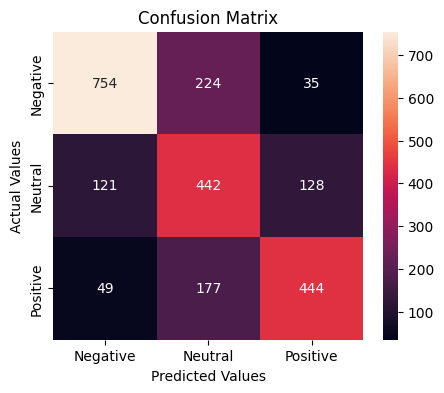

In [121]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [122]:
val_df.to_csv('train_validation.csv', columns=['text', 'label', 'char_count', 'pred', 'control', 'pred_name'])

## Inference

In [87]:
tokenized_ds['test']['text'][:30]

['y cuantas chanchas habran hecho para la salvadora de la democracia?.. emoji cara pensativa emoji',
 'tremenda joyita  emoji corazón morado emoji  emoji corazón morado emoji  emoji corazón morado emoji',
 'entre cabros se entienden altamirano gómez alain gerard... y de pasadita dale su beso y mepaso en su pelacho a la beto...  emoji cara llorando de risa emoji',
 'chino llevalo al camal, a ese puerco  emoji cara revolviéndose de la risa emoji  emoji cara revolviéndose de la risa emoji',
 'apoyo de 4 gato y un perro con virolo... emoji cara sonriente con lágrima emoji  emoji cara sonriendo con sudor frío emoji',
 'me enamore gente, después de ver full ch0las en stream me limpiastes los ojos',
 'henry loyola como cuando te digo "bebé se me ve bien" o "bebé buscame otra talla" y tú no colaboras amor   emoji cara decepcionada emoji  emoji cara decepcionada emoji  emoji cara decepcionada emoji',
 'esté cabeza de chancho  emoji nariz de cerdo emoji  burro',
 'lo de los instrumentos musicale

In [134]:
# encoded_data_test = tokenizer.batch_encode_plus(
#     val_df.text.values, 
#     add_special_tokens=config.add_special_tokens, 
#     return_attention_mask=config.return_attention_mask, 
#     pad_to_max_length=config.pad_to_max_length,
#     max_length=128, 
#     return_tensors=config.return_tensors
# )

In [127]:
test_df = ds['test'].to_pandas()

In [ ]:
#Evaluate the Model Qualitatively (Human Evaluation)

In [ ]:
#Evaluate the Model Quantitatively (with F1 Metric)

In [128]:
texts = test_df[0:20]['text']
human_baseline_labels = test_df[0:20]['label']

In [129]:
texts

0     y cuantas chanchas habran hecho para la salvad...
1                                   tremenda joyita 💜💜💜
2     entre cabros se entienden altamirano gómez ala...
3               chino llevalo al camal, a ese puerco 🤣🤣
4            apoyo de 4 gato y un perro con virolo...🥲😅
5     me enamore gente, después de ver full ch0las e...
6     henry loyola como cuando te digo "bebé se me v...
7                        esté cabeza de chancho 🐽 burro
8     lo de los instrumentos musicales está muy cool 👌🏻
9                 andy lopez 👉👈 chanchito .. costillas😋
10    uy qué recuerdos , mi.madre que ya no está en ...
11    danely mishell herrera carbajal no pasa nada c...
12    andres hurtado mis felicitaciones para usted x...
13    que monstruos son todos 🤭😜🤣😱 el único que se a...
14    un rico ceviche, helados a montón, los chupete...
15                       eres un enfermo, conchatumadre
16          a ver, sé bacán conmigo pues, conchatumadre
17     jaja 🤣🤣🤣 por las h... más tarde seguirá c

In [130]:
human_baseline_labels

0     1
1     0
2     0
3     0
4     0
5     2
6     1
7     0
8     2
9     2
10    2
11    0
12    0
13    0
14    2
15    0
16    0
17    0
18    2
19    0
Name: label, dtype: int64

In [131]:
def get_prediction(text):
    input_ids = tokenizer(text, return_tensors="pt", max_length=128).input_ids.to('cuda')
    logits = model(input_ids).logits
    probabilities = logits.softmax(dim=-1).tolist()[0]
    return np.argmax(probabilities).flatten()[0]

In [133]:
#original_model_summaries = []
model_classifications = []
for _, text in enumerate(texts):
    model_classifications.append(get_prediction(text))

In [84]:
model_classifications

[0, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2]

In [148]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_test_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_test_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/1899 [00:00<?, ?it/s]

In [149]:
len(pred_test_final)

1899

In [150]:
test_df.size

17091

In [152]:
# add pred into val_df
test_df["pred"] = pred_test_final

In [153]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [155]:
test_df

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
0,y cuantas chanchas habran hecho para la salvad...,1,Neutral,Y cuantas chanchas habran hecho para la salvad...,y cuantas chanchas habran hecho para la salvad...,11,15,70,70,1,Neutral
1,tremenda joyita 💜💜💜,0,Negative,Tremenda joyita 💜💜💜💜,tremenda joyita 💜💜💜,3,3,19,19,2,Positive
2,entre cabros se entienden altamirano gómez ala...,0,Negative,Entre cabros se entienden Altamirano Gómez Ala...,entre cabros se entienden altamirano gómez ala...,23,33,123,123,1,Neutral
3,"chino llevalo al camal, a ese puerco 🤣🤣",0,Negative,"Chino llevalo al camal, a ese puerco 🤣🤣",chino llevalo al camal a ese puerco 🤣🤣,8,12,39,39,0,Negative
4,apoyo de 4 gato y un perro con virolo...🥲😅,0,Negative,Apoyo de 4 gato y un perro con virolo...🥲😅,apoyo de 4 gato y un perro con virolo 🥲😅,9,11,42,42,1,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
1894,el loco wagner de grabación...🤔🤔🤔,1,Neutral,El loco Wagner de grabación...🤔🤔🤔🤔,el loco wagner de grabación 🤔🤔🤔,5,8,33,33,1,Neutral
1895,"como le vas a quebrar la cintura al cuevita, s...",2,Positive,"Como le vas a quebrar la cintura al Cuevita, s...",como le vas a quebrar la cintura al cuevita s...,18,21,98,98,0,Negative
1896,mi luca bello 🥳️🤗. excellente receta. 😍,2,Positive,Mi Luca bello 🥳❤️🤗. Excellente receta. 😍,mi luca bello 🥳️🤗 excellente receta 😍,7,11,40,40,2,Positive
1897,just lo maximo son caritos pero vale la pena d...,1,Neutral,JUST LO MAXIMO SON CARITOS PERO VALE LA PENA D...,just lo maximo son caritos pero vale la pena d...,14,15,72,72,2,Positive


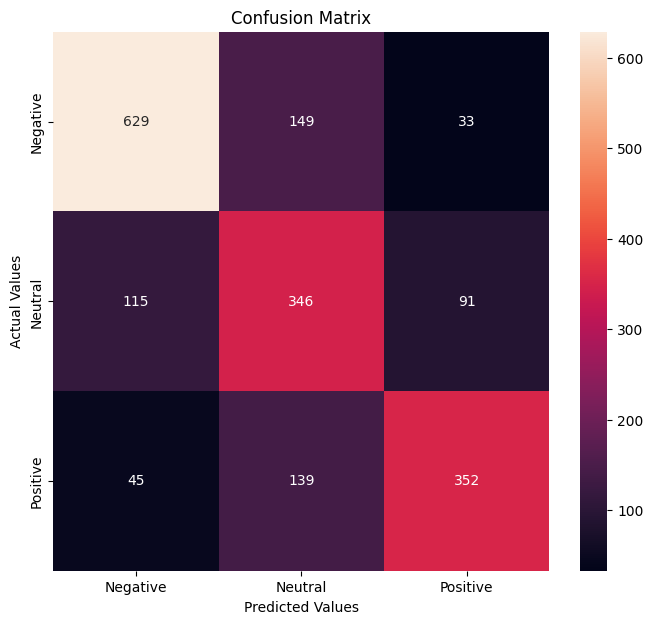

In [168]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(8,7))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('cm_test_predictions.png')
plt.show()

In [162]:
test_df

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
0,y cuantas chanchas habran hecho para la salvad...,1,Neutral,Y cuantas chanchas habran hecho para la salvad...,y cuantas chanchas habran hecho para la salvad...,11,15,70,70,1,Neutral
1,tremenda joyita 💜💜💜,0,Negative,Tremenda joyita 💜💜💜💜,tremenda joyita 💜💜💜,3,3,19,19,2,Positive
2,entre cabros se entienden altamirano gómez ala...,0,Negative,Entre cabros se entienden Altamirano Gómez Ala...,entre cabros se entienden altamirano gómez ala...,23,33,123,123,1,Neutral
3,"chino llevalo al camal, a ese puerco 🤣🤣",0,Negative,"Chino llevalo al camal, a ese puerco 🤣🤣",chino llevalo al camal a ese puerco 🤣🤣,8,12,39,39,0,Negative
4,apoyo de 4 gato y un perro con virolo...🥲😅,0,Negative,Apoyo de 4 gato y un perro con virolo...🥲😅,apoyo de 4 gato y un perro con virolo 🥲😅,9,11,42,42,1,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
1894,el loco wagner de grabación...🤔🤔🤔,1,Neutral,El loco Wagner de grabación...🤔🤔🤔🤔,el loco wagner de grabación 🤔🤔🤔,5,8,33,33,1,Neutral
1895,"como le vas a quebrar la cintura al cuevita, s...",2,Positive,"Como le vas a quebrar la cintura al Cuevita, s...",como le vas a quebrar la cintura al cuevita s...,18,21,98,98,0,Negative
1896,mi luca bello 🥳️🤗. excellente receta. 😍,2,Positive,Mi Luca bello 🥳❤️🤗. Excellente receta. 😍,mi luca bello 🥳️🤗 excellente receta 😍,7,11,40,40,2,Positive
1897,just lo maximo son caritos pero vale la pena d...,1,Neutral,JUST LO MAXIMO SON CARITOS PERO VALE LA PENA D...,just lo maximo son caritos pero vale la pena d...,14,15,72,72,2,Positive


In [163]:
test_df.to_csv('test_inference.csv', columns=['text', 'label','label_name', 'char_count', 'pred', 'pred_name'])